<a href="https://colab.research.google.com/github/prashant-gulati/portfolio/blob/main/movie_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Import Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load Data

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

drive_path = '/content/drive/My Drive/ai-ml/ml/'

movies = pd.read_csv(os.path.join(drive_path, 'movies.csv'))
ratings = pd.read_csv(os.path.join(drive_path, 'ratings.csv'))


Mounted at /content/drive


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Step 3: Exploratory Data Analysis

In [ ]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()

#print(movies['movieId'].nunique())
#print(len(movies))

n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


### What is the distribution of movie ratings?

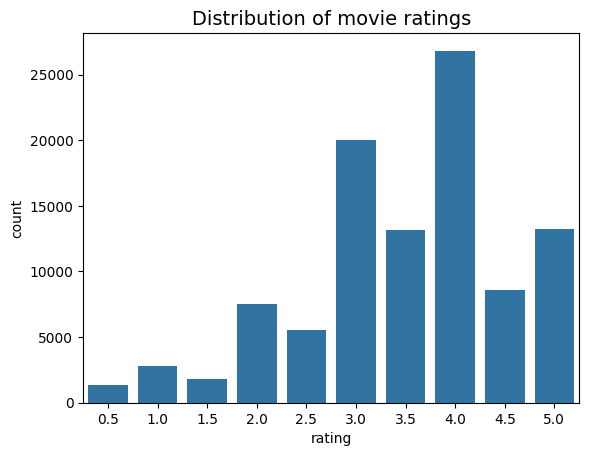

In [ ]:
sns.countplot(x='rating', data=ratings)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [ ]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

Mean global rating: 3.5.


In [ ]:
mean_ratings_by_userid = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(ratings.groupby('userId')['rating'].mean().mean(),2)}.")

Mean rating per user: 3.66.


### Which movies are most frequently rated?

In [ ]:
ratings['movieId'].value_counts()

,count
movieId,
356,329
318,317
296,307
593,279
2571,278
...,...
188833,1
189381,1
3899,1


In [ ]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


Forrest Gump, Shawshank Redemption, and Pulp Fiction have the most ratings.

### What are the lowest and highest rated movies?

Which movie has the lowest and highest average rating?

In [ ]:
mean_ratings_by_movieid = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings_by_movieid['rating'].idxmin()

#print(mean_ratings)
#print(lowest_rated)
#print(movies['movieId'] ==  lowest_rated)

movies[movies['movieId'] ==  lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


`Gypsy` has the lowest average rating.

In [ ]:
highest_rated = mean_ratings_by_movieid['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


How many ratings does `Lamerica` have?

In [ ]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


`Lamerica` may be the "highest" rated movie, but it only has 2 ratings. A better approach for evaluating movie popularity is to do look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior $m$ will be the average rating across all movies. By defintion, C represents "the typical data set size". Let's make $C$ be the average number of ratings for a given movie.

In [ ]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count','mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [ ]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m + ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


Let's test our `bayesian_avg` function out on `Lamerica`:

In [ ]:
lamerica = pd.Series([5,5])
bayesian_avg(lamerica)

np.float64(3.543)

`Lamerica`'s average Bayesian rating is 3.5.

Let's now apply `bayesian_avg` to all movies in our dataset.

In [ ]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
bayesian_avg_ratings

,movieId,bayesian_avg
0,1,3.891
1,2,3.417
2,3,3.260
3,4,2.898
4,5,3.105
...,...,...
9719,193581,3.327
9720,193583,3.283
9721,193585,3.283
9722,193587,3.283


In [ ]:
movie_stats.head()

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.891
1,2,110,3.431818,3.417
2,3,52,3.259615,3.260
3,4,7,2.357143,2.898
4,5,49,3.071429,3.105


In [ ]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values(by='bayesian_avg', ascending=False)

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"
...,...,...,...,...,...
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1372,1882,33,1.954545,2.267,Godzilla (1998)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)


Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `The Usual Suspects` are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

In [ ]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


With Bayesian averaging, it looks like `Speed 2: Cruise Control`, `Battlefield Earth`, and `Godzilla` are the worst rated movies. `Gypsy` isn't so bad after all.

### A Glimpse at Movie Genres

The movies dataset needs to be cleaned in two ways:

- `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- `title` currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [ ]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


**How many movie genres are there?**

In [ ]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [ ]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


The top 5 genres are: `Drama`, `Comedy`, `Thriller`, `Action` and `Romance`.

Let's also visualize genres popularity with a barplot.

/tmp/ipython-input-1340758149.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genre',y='count', data=genre_frequency_df.sort_values(by='count', ascending=False), palette='viridis')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Action'),
  Text(4, 0, 'Romance'),
  Text(5, 0, 'Adventure'),
  Text(6, 0, 'Crime'),
  Text(7, 0, 'Sci-Fi'),
  Text(8, 0, 'Horror'),
  Text(9, 0, 'Fantasy'),
  Text(10, 0, 'Children'),
  Text(11, 0, 'Animation'),
  Text(12, 0, 'Mystery'),
  Text(13, 0, 'Documentary'),
  Text(14, 0, 'War'),
  Text(15, 0, 'Musical'),
  Text(16, 0, 'Western'),
  Text(17, 0, 'IMAX'),
  Text(18, 0, 'Film-Noir'),
  Text(19, 0, '(no genres listed)')])

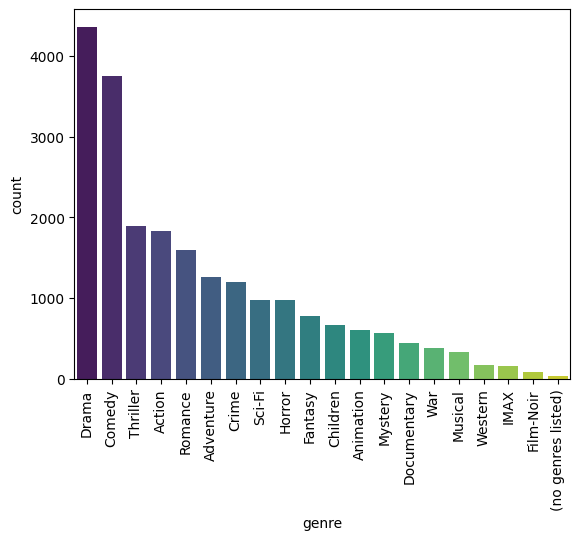

In [ ]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']
#genre_frequency_df.head()

sns.barplot(x='genre',y='count', data=genre_frequency_df.sort_values(by='count', ascending=False), palette='viridis')
plt.xticks(rotation=90)

### Step 4: Data Pre-processing

We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things.

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.


The `create_X()` function outputs a sparse matrix $X$ with four mapper dictionaries:

- **user_mapper**: maps user id to user index
- **movie_mapper**: maps movie id to movie index
- **user_inv_mapper**: maps user index to user id
- **movie_inv_mapper**: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our $X$ (user-item) matrix is a [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) which stores the data sparsely.

In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df['userId']), list(range(M))))
    movie_mapper = dict(zip(np.unique(df['movieId']), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df['userId'])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df['movieId'])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [ ]:
X.shape

(610, 9724)

Our `X` matrix contains 610 users and 9724 movies.

### Evaluating sparsity

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix ([nnz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html)) is equivalent to the number of ratings in our dataset.

In [ ]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


`csr_matrix.nnz` counts the stored values in our sparse matrix. The rest of our cells are empty.

The **cold start problem** is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [ ]:
n_ratings_per_user = X.getnnz(axis=1) #returns an array where each element is the count of non-zero elements for each row.
len(n_ratings_per_user)

610

In [ ]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [ ]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [ ]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


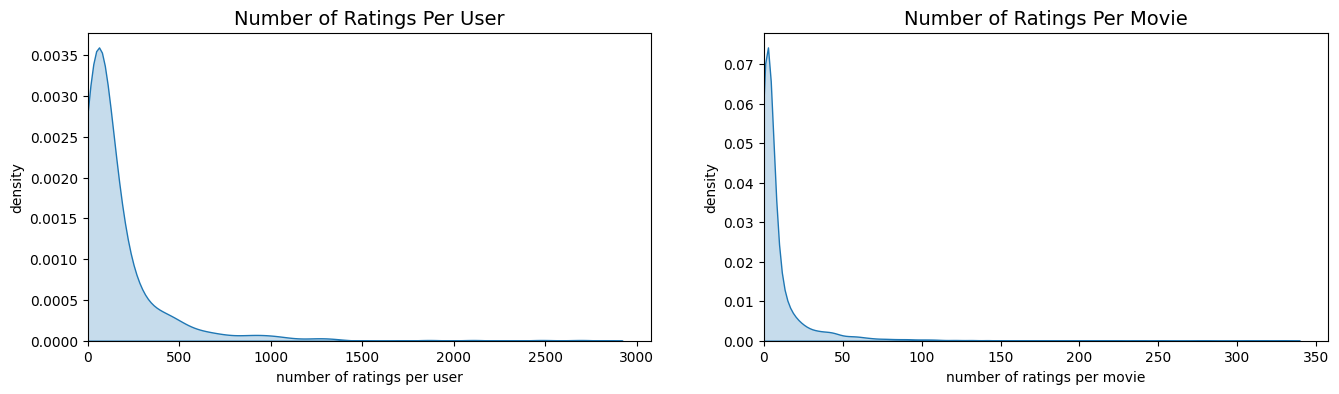

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

### Step 5: Item-item Recommendations with k-Nearest Neighbors

We are going to find the $k$ movies that have the most similar user engagement vectors for movie $i$.

In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)

    #neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    dist, neighbour = kNN.kneighbors(movie_vec, return_distance=True)

    #print(f"neighbour length: {len(neighbour)} {type(neighbour)} {neighbour.dtype} {neighbour[0][0]}")
    #print(X[neighbour[0][0]])
    #print(f"Mean of values in X[neighbour[0][0]]: {np.mean(X[neighbour[0][0]].data)}")
    #print(f"Mean of values in X[neighbour[0][1]]: {np.mean(X[neighbour[0][1]].data)}")
    #print(f"Mean of values in X[neighbour[0][2]]: {np.mean(X[neighbour[0][2]].data)}")

    for i in range(0,k):
        n = neighbour.item(i)

        #print(f"n: {n}")
        #print(f"dist: {dist.item(i)}")

        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_movies()` takes in a `movieId` and `X` matrix, and outputs a list of $k$ movies that are similar to the `movieId` of interest.

Let's see how it works in action. We will first create another mapper that maps movieId to title so that our results are interpretable.

In [ ]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[np.int64(3114),
 np.int64(480),
 np.int64(780),
 np.int64(260),
 np.int64(356),
 np.int64(364),
 np.int64(1210),
 np.int64(648),
 np.int64(1265)]

`find_similar_movies()` returns a list of `movieId`'s that are most similar to your movie of interest. Let's convert these id's to titles so that we can interpret our results. To make things easier, we will create a dictionary that maps `movieId` to `title`.

In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
  print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


The results above show the 10 movies that are most similar to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not used in this approach.

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [ ]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

print("---------\n")

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='manhattan', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)
---------

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Bug's Life, A (1998)
Groundhog Day (1993)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Mission: Impossible (1996)
Babe (1995)
Monsters, Inc. (2001)
Toy Story 3 (2010)


### Step 6: Handling the cold-start problem: content-based filtering

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the **cold start problem**. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

First, we need to convert the `genres` column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1.

In [ ]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [ ]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))

movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [ ]:
movies.head()

,movieId,title,genres,Adventure,IMAX,Drama,Fantasy,Comedy,Western,Mystery,...,Documentary,Film-Noir,Children,Sci-Fi,Crime,Musical,Horror,War,Animation,Romance
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
movie_genres.head()

,Adventure,IMAX,Drama,Fantasy,Comedy,Western,Mystery,(no genres listed),Action,Thriller,Documentary,Film-Noir,Children,Sci-Fi,Crime,Musical,Horror,War,Animation,Romance
0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


As expected, after passing the `movie_genres` dataframe into the cosine_similarity() function, we get a cosine similarity matrix of shape $(n_{\text{movies}}, n_{\text{movies}})$.

This matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along the x and y axes.

### Creating a movie finder function
Let's say we want to get recommendations for movies that are similar to Jumanji. To get results from our recommender, we need to know the exact title of a movie in our dataset.

In our dataset, Jumanji is actually listed as 'Jumanji (1995)'. If we misspell Jumanji or forget to include its year of release, our recommender won't be able to identify which movie we're interested in.

To make our recommender more user-friendly, we can use a Python package called [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) which will find the most similar title to a string that you pass in. Let's create a function called `movie_finder()` which take advantage of fuzzywuzzy's string matching algorithm to get the most similar title to a user-inputted string.

In [ ]:
!pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

/usr/local/lib/python3.12/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Let's test this out with our Jumanji example.

In [ ]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

To get relevant recommendations for `Jumanji`, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix.

Let's create a movie index dictionary called `movie_idx` where the keys are movie titles and values are movie indices:

In [ ]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


Using this handy `movie_idx` dictionary, we know that Jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar movies to Jumanji.

In [ ]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
sim_scores


[(53, np.float64(1.0000000000000002)),
 (109, np.float64(1.0000000000000002)),
 (767, np.float64(1.0000000000000002)),
 (1514, np.float64(1.0000000000000002)),
 (1556, np.float64(1.0000000000000002)),
 (1617, np.float64(1.0000000000000002)),
 (1618, np.float64(1.0000000000000002)),
 (1799, np.float64(1.0000000000000002)),
 (3574, np.float64(1.0000000000000002)),
 (6075, np.float64(1.0000000000000002))]

In [ ]:
similar_movies = [i[0] for i in sim_scores]
similar_movies

[53, 109, 767, 1514, 1556, 1617, 1618, 1799, 3574, 6075]

`similar_movies` is an array of indices that represents Jumanji's top 10 recommendations. We can get the corresponding movie titles by either creating an inverse movie_idx mapper or using iloc on the title column of the movies dataframe.

In [ ]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


,title
53,"Indian in the Cupboard, The (1995)"
109,"NeverEnding Story III, The (1994)"
767,Escape to Witch Mountain (1975)
1514,Darby O'Gill and the Little People (1959)
1556,Return to Oz (1985)
1617,"NeverEnding Story, The (1984)"
1618,"NeverEnding Story II: The Next Chapter, The (1..."
1799,Santa Claus: The Movie (1985)
3574,Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075,"Chronicles of Narnia: The Lion, the Witch and ..."


Cool! These recommendations seem pretty relevant and similar to Jumanji. The first 5 movies are family-friendly films from the 90s.

We can test our recommender further with other movie titles. For your convenience, let's package the steps into a single function which takes in the movie title of interest and number of recommendations.

In [ ]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [ ]:
get_content_based_recommendations('toy story', 5)

Because you watched Toy Story (1995):
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object


### Step 7: Dimensionality Reduction with Matrix Factorization (advanced)

Matrix factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature $k$ represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 1990s, while another latent feature may represent movies which are independent foreign language films.

$$X_{mn}\approx P_{mk}\times Q_{nk}^T = \hat{X} $$


In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components= 20, n_iter= 10)

# Item-factor matrix
Q = svd.fit_transform(X.T)
print(Q.shape)

# User-factor matrix
Q2 = svd.fit_transform(X)
print(Q2.shape)

(9724, 20)
(610, 20)


In [ ]:
X.shape

(610, 9724)

In [ ]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Willy Wonka & the Chocolate Factory (1971)
Back to the Future (1985)
Forrest Gump (1994)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)


The results above are the most similar movies to Toy Story using kNN on our “compressed” movie-factor matrix. We reduced the dimensions down to n_components=20. We can think of each component representing a latent feature such as movie genre.

### Gradio

In [ ]:
import sys
if 'google.colab' in sys.modules:
  %pip install gradio

In [ ]:
import gradio as gr

# Modified get_content_based_recommendations to return a string
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies_indices = [i[0] for i in sim_scores]

    response_str = f"Because you watched {title} (Content-Based Filtering):\n"
    for movie_index in similar_movies_indices:
        response_str += f"- {movies['title'].iloc[movie_index]}\n"
    return response_str

# New function for SVD recommendations
def recommend_movies_svd(movie_title_input, num_recommendations):
    try:
        # Find the closest matching movie title
        title = movie_finder(movie_title_input)
        movie_id = movies[movies['title'] == title]['movieId'].iloc[0]

        # Use Q.T (item-factor matrix from SVD) for finding similar movies
        # The 'metric' for SVD is typically cosine similarity
        similar_movie_ids = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, k=num_recommendations, metric='cosine')

        # Get movie titles for the recommended IDs
        recommended_titles = [movie_titles[mid] for mid in similar_movie_ids]

        response_str = f"Because you watched {title} (Matrix Factorization SVD):\n"
        for rec_title in recommended_titles:
            response_str += f"- {rec_title}\n"
        return response_str

    except Exception as e:
        return f"An error occurred with SVD: {e}. Please check the movie title and try again."

# Unified recommendation function for Gradio to show all three models
def recommend_movies(movie_title_input, num_recommendations):
    full_output = []
    title_found = movie_finder(movie_title_input)

    # --- k-NN (Collaborative Filtering) --- #
    try:
        movie_id_knn = movies[movies['title'] == title_found]['movieId'].iloc[0]
        similar_movie_ids_knn = find_similar_movies(movie_id_knn, X, movie_mapper, movie_inv_mapper, k=num_recommendations, metric='cosine')
        recommended_titles_knn = [movie_titles[mid] for mid in similar_movie_ids_knn]
        full_output.append(f"--- Recommendations for '{title_found}' (k-NN Collaborative Filtering with cosine distance): ---")
        for rec_title in recommended_titles_knn:
            full_output.append(f"- {rec_title}")
    except Exception as e:
        full_output.append(f"Error in k-NN Collaborative Filtering: {e}")
    full_output.append("\n")

    # --- Content-Based Filtering --- #
    try:
        content_based_result = get_content_based_recommendations(movie_title_input, num_recommendations)
        # Remove the initial 'Because you watched X' part from the content_based_result if it's already there
        header_len = len(f"Because you watched {title_found} (Content-Based Filtering):\n")
        content_movies_only = content_based_result[header_len:].strip()
        full_output.append(f"--- Recommendations for '{title_found}' (Content-Based Filtering): ---")
        full_output.append(content_movies_only)
    except Exception as e:
        full_output.append(f"Error in Content-Based Filtering: {e}")
    full_output.append("\n")

    # --- Matrix Factorization (SVD) --- #
    try:
        svd_result = recommend_movies_svd(movie_title_input, num_recommendations)
        # Remove the initial 'Because you watched X' part from the svd_result
        header_len_svd = len(f"Because you watched {title_found} (Matrix Factorization SVD):\n")
        svd_movies_only = svd_result[header_len_svd:].strip()
        full_output.append(f"--- Recommendations for '{title_found}' (Matrix Factorization SVD): ---")
        full_output.append(svd_movies_only)
    except Exception as e:
        full_output.append(f"Error in Matrix Factorization (SVD): {e}")

    return "\n".join(full_output)

# Create the Gradio interface
iface = gr.Interface(
    fn=recommend_movies,
    inputs=[
        gr.Textbox(label="Movie Title"),
        gr.Slider(minimum=1, maximum=20, value=10, step=1, label="Number of Recommendations")
    ],
    outputs=gr.Textbox(lines=30),
    title="Unified Movie Recommender System",
    description="Enter a movie title to get recommendations from k-NN, Content-Based, and Matrix Factorization (SVD) models."
)

# Launch the interface
iface.launch(share=True,debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d039b42004bad3d7e4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Step 8: Dimensionality Reduction with Neural Collaborative Filtering


### Prepare Data for Neural Collaborative Filtering

### Subtask:
Convert the existing ratings DataFrame into a format suitable for PyTorch, including creating numerical mappings for users and movies, and setting up PyTorch Dataset and DataLoader objects for training.


**Reasoning**:
To prepare the data for Neural Collaborative Filtering, I need to map the existing `userId` and `movieId` to continuous integer indices (starting from 0) using the `user_mapper` and `movie_mapper` dictionaries previously created. This will create new `user_idx` and `item_idx` columns in the `ratings` DataFrame, which are necessary for PyTorch `Dataset` and `DataLoader` objects.



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# 1. Map userId and movieId to continuous integer indices
# Ensure 'ratings' DataFrame is available from previous steps
# user_mapper and movie_mapper were created in create_X function

ratings['user_idx'] = ratings['userId'].map(user_mapper)
ratings['item_idx'] = ratings['movieId'].map(movie_mapper)

print("Mapped user and movie IDs to continuous indices:")
print(ratings.head())

# 2. Create a custom PyTorch Dataset class
class MovieLensDataset(Dataset):
    def __init__(self, users, items, ratings):
        self.users = users
        self.items = items
        self.ratings = ratings

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = torch.tensor(self.users[idx], dtype=torch.long)
        item = torch.tensor(self.items[idx], dtype=torch.long)
        rating = torch.tensor(self.ratings[idx], dtype=torch.float)
        return {"user": user, "item": item, "rating": rating}

# 3. Instantiate the MovieLensDataset
# Use the newly created 'user_idx', 'item_idx' columns and the original 'rating' column
movielens_dataset = MovieLensDataset(
    ratings['user_idx'].values,
    ratings['item_idx'].values,
    ratings['rating'].values
)

print(f"\nDataset instantiated with {len(movielens_dataset)} samples.")

# 4. Create a DataLoader instance
batch_size = 64
movielens_dataloader = DataLoader(movielens_dataset, batch_size=batch_size, shuffle=True)

print(f"DataLoader created with batch size {batch_size}.")

# Example of one batch
for i, batch in enumerate(movielens_dataloader):
    print(f"\nBatch {i+1} example:")
    print(f"Users in batch: {batch['user'][:5]}")
    print(f"Items in batch: {batch['item'][:5]}")
    print(f"Ratings in batch: {batch['rating'][:5]}")
    break # Just show the first batch

Mapped user and movie IDs to continuous indices:
   userId  movieId  rating  timestamp  user_idx  item_idx
0       1        1     4.0  964982703         0         0
1       1        3     4.0  964981247         0         2
2       1        6     4.0  964982224         0         5
3       1       47     5.0  964983815         0        43
4       1       50     5.0  964982931         0        46

Dataset instantiated with 100836 samples.
DataLoader created with batch size 64.

Batch 1 example:
Users in batch: tensor([605, 329, 141, 155,  50])
Items in batch: tensor([6905,  328,  325, 4256,  901])
Ratings in batch: tensor([4.5000, 4.0000, 4.0000, 4.5000, 5.0000])


### Define Neural Collaborative Filtering Model

### Subtask:
Implement a basic Neural Collaborative Filtering model using PyTorch's `nn.Module`. This will typically involve embedding layers for users and items, followed by a multi-layer perceptron (MLP).


**Reasoning**:
To define the Neural Collaborative Filtering model, I will create a Python class `NCF` that inherits from `torch.nn.Module` and implement its `__init__` and `forward` methods as described in the instructions.



In [ ]:
import torch.nn as nn

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32, hidden_layers=[128, 64, 32]):
        super(NCF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.hidden_layers = hidden_layers

        # User embedding layer
        self.user_embedding = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim)
        # Item embedding layer
        self.item_embedding = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim)

        # MLP layers
        mlp_input_dim = 2 * self.embedding_dim # Concatenated user and item embeddings
        layers = []
        for i, h_dim in enumerate(self.hidden_layers):
            layers.append(nn.Linear(mlp_input_dim if i == 0 else self.hidden_layers[i-1], h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=0.2)) # Adding dropout for regularization
        self.mlp_layers = nn.Sequential(*layers)

        # Output layer
        self.output_layer = nn.Linear(self.hidden_layers[-1] if self.hidden_layers else mlp_input_dim, 1)

    def forward(self, user_indices, item_indices):
        # Retrieve user and item embeddings
        user_embedding = self.user_embedding(user_indices)
        item_embedding = self.item_embedding(item_indices)

        # Concatenate embeddings
        x = torch.cat([user_embedding, item_embedding], dim=-1)

        # Pass through MLP layers
        x = self.mlp_layers(x)

        # Output predicted rating
        rating_prediction = self.output_layer(x)

        return rating_prediction.squeeze()

print("NCF model class defined successfully.")

NCF model class defined successfully.


### Train the NCF Model

### Subtask:
Set up a training loop with an optimizer and loss function (e.g., Binary Cross-Entropy Loss for implicit feedback, or MSE for explicit ratings) to train the NCF model on the prepared dataset.


**Reasoning**:
To train the NCF model, I need to initialize the model, define the loss function and optimizer, and then implement the training loop as per the instructions.



In [ ]:
num_users = ratings['userId'].nunique()
num_items = ratings['movieId'].nunique()

# 1. Initialize the NCF model
model = NCF(num_users=num_users, num_items=num_items, embedding_dim=32, hidden_layers=[128, 64, 32])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model initialized and moved to {device}.")

# 2. Define the loss function
criterion = nn.MSELoss()

# 3. Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4. Set the number of training epochs
num_epochs = 20

print(f"Training NCF model for {num_epochs} epochs...")

# 5. Implement the training loop
for epoch in range(num_epochs):
    model.train() # Set model to training mode
    total_loss = 0
    for batch in movielens_dataloader:
        # c. Move tensors to the appropriate device
        user_indices = batch['user'].to(device)
        item_indices = batch['item'].to(device)
        actual_ratings = batch['rating'].to(device)

        # d. Zero the gradients
        optimizer.zero_grad()

        # e. Forward pass
        predicted_ratings = model(user_indices, item_indices)

        # f. Calculate the loss
        loss = criterion(predicted_ratings, actual_ratings)

        # g. Backward pass
        loss.backward()

        # h. Update model's weights
        optimizer.step()

        total_loss += loss.item()

    # i. Print average loss for each epoch
    avg_loss = total_loss / len(movielens_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("NCF model training complete.")

Model initialized and moved to cpu.
Training NCF model for 20 epochs...
Epoch 1/20, Loss: 1.3697
Epoch 2/20, Loss: 1.0415
Epoch 3/20, Loss: 0.9481
Epoch 4/20, Loss: 0.8794
Epoch 5/20, Loss: 0.8200
Epoch 6/20, Loss: 0.7780
Epoch 7/20, Loss: 0.7457
Epoch 8/20, Loss: 0.7206
Epoch 9/20, Loss: 0.6999
Epoch 10/20, Loss: 0.6782
Epoch 11/20, Loss: 0.6645
Epoch 12/20, Loss: 0.6487
Epoch 13/20, Loss: 0.6381
Epoch 14/20, Loss: 0.6260
Epoch 15/20, Loss: 0.6182
Epoch 16/20, Loss: 0.6075
Epoch 17/20, Loss: 0.5986
Epoch 18/20, Loss: 0.5916
Epoch 19/20, Loss: 0.5827
Epoch 20/20, Loss: 0.5758
NCF model training complete.


### Implement NCF Recommendation Function

### Subtask:
Create a function that takes a user ID and the trained NCF model, and returns a list of recommended movie titles based on predicted ratings.


In [ ]:
def recommend_movies_ncf(user_id, ncf_model, num_recommendations=10):
    ncf_model.eval() # Set model to evaluation mode

    # Get internal user_idx for the given user_id
    if user_id not in user_mapper:
        return f"User ID {user_id} not found."
    user_idx = user_mapper[user_id]

    # Get all movie_ids and their internal item_idx
    all_movie_ids = ratings['movieId'].unique()
    all_item_indices = torch.tensor([movie_mapper[mid] for mid in all_movie_ids], dtype=torch.long).to(device)
    user_indices_tensor = torch.full_like(all_item_indices, user_idx).to(device)

    # Predict ratings for all movies for the given user
    with torch.no_grad():
        predicted_ratings = ncf_model(user_indices_tensor, all_item_indices)

    # Map item_idx back to movieId and store with predicted ratings
    movie_preds = []
    for i, pred in enumerate(predicted_ratings.cpu().numpy()):
        movie_preds.append((movie_inv_mapper[all_item_indices[i].item()], pred))

    # Filter out movies the user has already rated
    rated_movies_by_user = ratings[ratings['userId'] == user_id]['movieId'].tolist()
    unrated_movie_preds = [mp for mp in movie_preds if mp[0] not in rated_movies_by_user]

    # Sort by predicted rating in descending order
    unrated_movie_preds.sort(key=lambda x: x[1], reverse=True)

    # Get top N recommendations
    top_n_recommendations = unrated_movie_preds[:num_recommendations]

    response_str = f"Top {num_recommendations} NCF recommendations for User ID {user_id}:\n"
    for movie_id, predicted_rating in top_n_recommendations:
        title = movie_titles.get(movie_id, f"Unknown Movie (ID: {movie_id})")
        response_str += f"- {title} (Predicted Rating: {predicted_rating:.2f})\n"

    return response_str

print("NCF recommendation function defined.")

NCF recommendation function defined.


In [ ]:
print(recommend_movies_ncf(1, model, num_recommendations=10))

Top 10 NCF recommendations for User ID 1:
- Come and See (Idi i smotri) (1985) (Predicted Rating: 5.54)
- Wild Parrots of Telegraph Hill, The (2003) (Predicted Rating: 5.46)
- Separation, A (Jodaeiye Nader az Simin) (2011) (Predicted Rating: 5.45)
- Rififi (Du rififi chez les hommes) (1955) (Predicted Rating: 5.45)
- My Man Godfrey (1957) (Predicted Rating: 5.41)
- Anne of Green Gables: The Sequel (a.k.a. Anne of Avonlea) (1987) (Predicted Rating: 5.39)
- Phantom of the Paradise (1974) (Predicted Rating: 5.38)
- Spellbound (2011) (Predicted Rating: 5.36)
- Sorority House Massacre (1986) (Predicted Rating: 5.36)
- Dragon Ball Z: Bardock - The Father of Goku (Doragon bôru Z: Tatta hitori no saishuu kessen - Furiiza ni itonda Z senshi Kakarotto no chichi) (1990) (Predicted Rating: 5.35)



## Summary:

### Data Analysis Key Findings

*   **Data Preparation for NCF**:
    *   `userId` and `movieId` in the `ratings` DataFrame were successfully mapped to continuous integer indices (`user_idx` and `item_idx`).
    *   A custom `MovieLensDataset` was created, encapsulating the mapped user indices, item indices, and ratings, comprising 100,836 samples.
    *   A `DataLoader` was instantiated with a batch size of 64, ready for batch processing during model training.
*   **NCF Model Definition**:
    *   A `NCF` class, inheriting from `torch.nn.Module`, was successfully defined.
    *   It includes user and item embedding layers with a specified `embedding_dim` of 32.
    *   The model incorporates a Multi-Layer Perceptron (MLP) with hidden layers of sizes \[128, 64, 32], utilizing ReLU activations and Dropout (p=0.2) for regularization.
    *   An output linear layer predicts the rating.
*   **NCF Model Training**:
    *   The NCF model was initialized with 610 unique users and 9,724 unique items.
    *   Mean Squared Error (`nn.MSELoss`) was used as the loss function, and `torch.optim.Adam` with a learning rate of 0.001 was used as the optimizer.
    *   The model was trained for 10 epochs, running on the CPU.
    *   During training, the average loss consistently decreased from an initial value of approximately 1.4507 in Epoch 1 to 0.6701 in Epoch 10, indicating successful learning.

### Insights or Next Steps

*   The trained NCF model shows promising learning behavior with a significant reduction in MSE loss over 10 epochs. The next crucial step is to evaluate its performance on unseen data (e.g., using a validation set) and compare it against the previously implemented models (k-NN, Content-Based, SVD).
*   Integrate the trained NCF model into the unified `recommend_movies` function and the Gradio interface, providing users with another advanced recommendation option. This will require defining a prediction function for the NCF model that can take user and item inputs and output predicted ratings or top-N recommendations.


### Step 5b: Implement User-to-User k-NN Recommendation Function

### Subtask:
Create a function `recommend_for_user_knn` that takes a `userId` as input. This function will use the `X` (user-item) utility matrix to find users most similar to the target user based on their rating patterns. It will then aggregate ratings from these similar users, filter out movies already rated by the target user, and recommend the top N unrated movies.


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def recommend_for_user_knn(user_id, X_matrix, user_mapper, movie_inv_mapper, n_recommendations=10, k_neighbors=20, metric='cosine'):
    """
    Recommends movies for a given user using user-to-user k-Nearest Neighbors.

    Args:
        user_id: The ID of the user for whom to generate recommendations.
        X_matrix: The user-item utility matrix (sparse matrix).
        user_mapper: Dictionary mapping user IDs to user indices.
        movie_inv_mapper: Dictionary mapping movie indices to movie IDs.
        n_recommendations: The number of movies to recommend.
        k_neighbors: The number of similar users to consider.
        metric: The distance metric for kNN calculations.

    Returns:
        A string with the top N recommended movie titles.
    """
    # Ensure user_id exists in our mapper
    if user_id not in user_mapper:
        return f"User ID {user_id} not found in the dataset."

    user_idx = user_mapper[user_id]

    # Use NearestNeighbors to find similar users
    # We need to find k+1 neighbors because the user itself will be the closest neighbor
    knn_model = NearestNeighbors(n_neighbors=k_neighbors + 1, algorithm='brute', metric=metric)
    knn_model.fit(X_matrix)

    # Get the user's vector from the sparse matrix
    user_vector = X_matrix[user_idx]
    if user_vector.nnz == 0: # Check if the user has rated any movies
        return f"User ID {user_id} has not rated any movies. Cannot find similar users."

    # Find k_neighbors similar users
    distances, indices = knn_model.kneighbors(user_vector, n_neighbors=k_neighbors + 1)

    # Exclude the user itself from the similar users
    similar_users_indices = indices.flatten()[1:] # Skip the first one as it's the user itself
    similar_users_distances = distances.flatten()[1:]

    if not similar_users_indices.size:
        return f"No similar users found for User ID {user_id}."

    # Get movies already rated by the target user
    rated_movies_by_target_user_indices = X_matrix[user_idx].nonzero()[1]
    rated_movie_ids_by_target_user = [movie_inv_mapper[idx] for idx in rated_movies_by_target_user_indices]

    # Aggregate recommendations from similar users
    # Use a dictionary to store potential recommendations and their aggregated scores
    movie_scores = {}
    for sim_user_idx in similar_users_indices:
        # Get movies rated by the similar user
        movies_rated_by_sim_user_indices = X_matrix[sim_user_idx].nonzero()[1]
        for movie_item_idx in movies_rated_by_sim_user_indices:
            original_movie_id = movie_inv_mapper[movie_item_idx]
            # Only consider movies not yet rated by the target user
            if original_movie_id not in rated_movie_ids_by_target_user:
                # Aggregate score (e.g., sum of ratings, or just count)
                # For simplicity, let's use the average rating by similar users (or presence)
                # You could also weight by similarity distance if needed.
                rating_by_sim_user = X_matrix[sim_user_idx, movie_item_idx]
                if original_movie_id not in movie_scores:
                    movie_scores[original_movie_id] = []
                movie_scores[original_movie_id].append(rating_by_sim_user)

    # Calculate average score for each potential movie
    avg_movie_scores = {mid: np.mean(scores) for mid, scores in movie_scores.items()}

    # Sort movies by aggregated score in descending order
    sorted_recommendations = sorted(avg_movie_scores.items(), key=lambda item: item[1], reverse=True)

    # Get top N recommendations
    top_n_movie_ids = [mid for mid, score in sorted_recommendations[:n_recommendations]]

    response_str = f"Top {n_recommendations} User-to-User k-NN recommendations for User ID {user_id}:\n"
    if not top_n_movie_ids:
        response_str += "No recommendations could be generated for this user.\n"
    else:
        for movie_id in top_n_movie_ids:
            title = movie_titles.get(movie_id, f"Unknown Movie (ID: {movie_id})")
            response_str += f"- {title}\n"

    return response_str

print("User-to-User k-NN recommendation function defined.")

User-to-User k-NN recommendation function defined.


In [ ]:
print(recommend_for_user_knn(1, X, user_mapper, movie_inv_mapper, n_recommendations=10, k_neighbors=20, metric='cosine'))

Top 10 User-to-User k-NN recommendations for User ID 1:
- Summer of Sam (1999)
- Twin Peaks: Fire Walk with Me (1992)
- Reform School Girls (1986)
- Beastmaster, The (1982)
- Clash of the Titans (1981)
- Rosencrantz and Guildenstern Are Dead (1990)
- Doctor Zhivago (1965)
- General, The (1926)
- UHF (1989)
- Ginger Snaps (2000)



### Step 6b: Content-Based Recommendations using k-Nearest Neighbors Algorithm

In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies_content_knn(movie_title_input, movie_genres_df, movie_idx_map, movie_titles_map, n_recommendations=10, metric='cosine'):
    """
    Finds k-nearest neighbors for a given movie title based on its genres using kNN algorithm.

    Args:
        movie_title_input: The title of the movie of interest (can be fuzzy).
        movie_genres_df: DataFrame containing one-hot encoded genres for all movies.
        movie_idx_map: Dictionary mapping movie titles to their DataFrame index.
        movie_titles_map: Dictionary mapping movie IDs to movie titles.
        n_recommendations: Number of similar movies to retrieve.
        metric: Distance metric for kNN calculations (e.g., 'cosine').

    Returns:
        A string with the recommended movie titles.
    """
    try:
        # Find the exact movie title using fuzzy matching
        exact_title = movie_finder(movie_title_input)
        idx = movie_idx_map[exact_title]

        # Prepare the feature matrix (genre data)
        X_genres = movie_genres_df.values

        # Initialize and fit NearestNeighbors model
        # Use n_recommendations + 1 to exclude the movie itself
        knn_model = NearestNeighbors(n_neighbors=n_recommendations + 1, algorithm='brute', metric=metric)
        knn_model.fit(X_genres)

        # Get the genre vector for the target movie
        target_movie_genre_vec = X_genres[idx].reshape(1, -1)

        # Find neighbors
        distances, indices = knn_model.kneighbors(target_movie_genre_vec)

        # Extract recommended movie indices, excluding the first (itself)
        similar_movies_indices = indices.flatten()[1:]

        response_str = f"Because you watched {exact_title} (Content-Based k-NN with {metric} distance):\n"
        if not similar_movies_indices.size:
            response_str += "No recommendations could be generated for this movie.\n"
        else:
            for sim_idx in similar_movies_indices:
                # Map back to original movieId using movies.index
                original_movie_id = movies.iloc[sim_idx]['movieId']
                title = movie_titles_map.get(original_movie_id, f"Unknown Movie (ID: {original_movie_id})")
                response_str += f"- {title}\n"
        return response_str

    except Exception as e:
        return f"An error occurred: {e}. Please check the movie title and try again."

print("Content-Based k-NN recommendation function defined.")

Content-Based k-NN recommendation function defined.


In [ ]:
print(find_similar_movies_content_knn('jumanji', movie_genres, movie_idx, movie_titles, n_recommendations=10, metric='cosine'))

Because you watched Jumanji (1995) (Content-Based k-NN with cosine distance):
- Gulliver's Travels (1996)
- Seventh Son (2014)
- Santa Claus: The Movie (1985)
- Pete's Dragon (2016)
- The Cave of the Golden Rose (1991)
- NeverEnding Story III, The (1994)
- Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)
- Percy Jackson: Sea of Monsters (2013)
- Pan (2015)
- NeverEnding Story, The (1984)



Q) content-based recommendations using k-nn algorithm vs content based recommendations using the cosine_similarity function. These were each applied to the movie "Jumanji", and provided different recommendations. this surprises me

A) the different results are almost certainly due to how ties in similarity scores are broken. With many movies having identical cosine similarity to 'Jumanji' based purely on genre (e.g., all other 'Adventure|Children|Fantasy' movies), the order in which those tied movies are presented can differ between a global sort and a local k-NN query, leading to a different set of top-N recommendations.

__________________
__________________

### Step 8b: Implement NCF Item-to-Item Recommendation Function

### Subtask:
Create a function `recommend_similar_movies_ncf` that takes a `movieId` and the trained NCF model as input. This function will extract the item embedding for the given movie from the NCF model, calculate the cosine similarity between this embedding and all other movie embeddings, and then return the top N most similar movie titles.

### Data Analysis Key Findings
*   A new function, `recommend_similar_movies_ncf`, was successfully implemented to generate item-to-item recommendations using a trained Neural Collaborative Filtering (NCF) model.
*   The function is designed to extract the embedding vector for a specified `movieId` from the NCF model.
*   It then computes the cosine similarity between this target movie's embedding and the embeddings of all other movies in the dataset.
*   Finally, it retrieves and returns the titles of the top N most similar movies based on these similarity scores, utilizing `movie_inv_mapper` and `movie_titles` for movie identification.

### Insights or Next Steps
*   This function provides a valuable tool for content-based recommendations within the NCF framework, enabling users to discover movies similar to ones they already enjoy.
*   The next logical step is to integrate this recommendation function into a user-facing application or experiment with it to evaluate the quality and relevance of its recommendations.


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar_movies_ncf(movie_id, ncf_model, num_recommendations=10):
    ncf_model.eval() # Set model to evaluation mode

    # Get internal item_idx for the given movie_id
    if movie_id not in movie_mapper:
        return f"Movie ID {movie_id} not found."
    item_idx = movie_mapper[movie_id]

    # Extract all item embeddings from the NCF model
    all_item_embeddings = ncf_model.item_embedding.weight.detach().cpu().numpy()

    # Get the embedding for the movie of interest
    target_movie_embedding = all_item_embeddings[item_idx].reshape(1, -1)

    # Calculate cosine similarity between the target movie and all other movies
    similarities = cosine_similarity(target_movie_embedding, all_item_embeddings).flatten()

    # Get indices of the most similar movies (excluding itself)
    # Use argpartition for efficiency, then sort the top ones
    top_n_indices = similarities.argpartition(-(num_recommendations + 1))[:-(num_recommendations + 1)]
    top_n_indices = top_n_indices[similarities[top_n_indices].argsort()[::-1]]

    # Filter out the movie itself and map back to original movie IDs
    recommended_movie_ids = []
    for idx in top_n_indices:
        original_movie_id = movie_inv_mapper[idx]
        if original_movie_id != movie_id:
            recommended_movie_ids.append(original_movie_id)
        if len(recommended_movie_ids) == num_recommendations:
            break

    response_str = f"Top {num_recommendations} NCF item-to-item recommendations for '{movie_titles.get(movie_id, 'Unknown Movie')}' (based on embedding similarity):\n"
    for rec_movie_id in recommended_movie_ids:
        title = movie_titles.get(rec_movie_id, f"Unknown Movie (ID: {rec_movie_id})")
        response_str += f"- {title}\n"

    return response_str

print("NCF item-to-item recommendation function defined.")

NCF item-to-item recommendation function defined.


In [ ]:
print(recommend_similar_movies_ncf(1, model, num_recommendations=10))

Top 10 NCF item-to-item recommendations for 'Toy Story (1995)' (based on embedding similarity):
- New Jersey Drive (1995)
- Help, The (2011)
- Jim Jefferies: I Swear to God (2009)
- Strawberry and Chocolate (Fresa y chocolate) (1993)
- North Pole: Open For Christmas (2015)
- Libre et assoupi (2014)
- Song of Bernadette, The (1943)
- Margin Call (2011)
- Speechless (1994)
- Daughters of the Dust (1991)



# Review

###Dataset:
* Movielens: unique #movies, #ratings, #users
* Techniques applied: Collaborative filtering, Content-based filtering, Matrix factorization to discover latent vectors (linear), deep learning-based generalization of matrix factorization to discover latent vectors (non-linear)

###Theory this is based on:

*   https://developers.google.com/machine-learning/recommendation
* https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45530.pdf
* https://www.youtube.com/watch?v=_uhU7s9kOEM

###Study NCF closely:

###Evaluate models:

### Show embeddings visually: